## Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ripser
from persim import plot_diagrams
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist, squareform
import itertools
plt.style.use("seaborn-v0_8-dark")

In [3]:
sweden = pd.read_csv("wid_all_data/WID_data_SE.CSV", sep = ";")
#sweden
sweden_shares = sweden[sweden["variable"].str.contains(r'^s.*', regex=True)]
sweden_shares

,country,variable,percentile,year,value,age,pop
12154,SE,sfiinct992,p99p99.5,1903,0.0450,992,t
12155,SE,sfiinct992,p99p99.5,1907,0.0486,992,t
12156,SE,sfiinct992,p99p99.5,1911,0.0433,992,t
12157,SE,sfiinct992,p99p99.5,1912,0.0460,992,t
12158,SE,sfiinct992,p99p99.5,1916,0.0507,992,t
...,...,...,...,...,...,...,...
293374,SE,sptincj992,p9p100,2018,0.9973,992,j
293375,SE,sptincj992,p9p100,2019,0.9973,992,j
293376,SE,sptincj992,p9p100,2020,0.9974,992,j
293377,SE,sptincj992,p9p100,2021,0.9975,992,j


In order to narrow the scope of analysis I have decided to look only at the variables representing shares of quantities. The definitions of the quantities being measured is the following:

1. **Post-tax disposable income:** Pre-tax income-Taxes on production (net)-Current taxes on income and wealth + Social assistance benefits in cash
2. **Post-tax national income:** Post-tax disposable income + Public spending
3. **Fiscal income:** [Fiscal labour income [total fiscal income ranking]]+[Fiscal capital income [total fiscal income ranking]]
4. **Net personal wealth:** [Personal non-financial assets]+[Personal financial assets]-[Personal debt]
5. **Pre-tax Labor Income** Pre-tax labor income [pre-tax labor income ranking]=Compensation of employees [pre-tax labor income ranking]+Labor component of net mixed income [pre-tax labor income ranking]+Pensions and social insurance income (labor share) [pre-tax labor income ranking]
6. **Pre-tax national income** =Pre-tax labor income [total pre-tax income ranking]+Pre-tax capital income [total pre-tax income ranking]

To start with, I shall consider post-tax disposable income. These data, for each country and year, basically provide an approximation of the income distribution of that country, for that year (normalized by the total income). As such, we may form a distance space of countries suitable for topological data analysis by considering the $L^p$-distance between distributions.

According to Piketty, well known measures of economic inequality such as the Gini coefficient oversimplify inequality regimes since they summarize the distributions of wealth and income into single numbers (Piketty, *Capital in the 21st Century*, 2014). An aim of this project, then, is to provide a comparative analysis of inequality regimes that manages to compare **entire distributions** in a stable and meaningful way.

Furthermore, a topological analysis may provide insight into the structure or shape of the resulting distance space. An interesting question might be how the homology is affected by world events such as the latest pandemic.

In [4]:
sweden_metadata = pd.read_csv("wid_all_data/WID_metadata_SE.CSV", sep=";")
# sweden_metadata
sweden_shares_metadata = sweden_metadata[
    sweden_metadata["variable"].str.contains(r"^s.*", regex=True)
]
sweden_shares_metadata

,country,variable,age,pop,countryname,shortname,simpledes,technicaldes,shorttype,longtype,shortpop,longpop,shortage,longage,unit,source,method,extrapolation,data_points
1194,SE,scaincj992,992,j,Sweden,Post-tax disposable income,Post-tax private income corresponds to all sou...,Post-tax disposable income=Pre-tax income-Taxe...,Share,Income or wealth shares. When the associated p...,equal-split adults,The base unit is the individual (rather than t...,Adults,The population is comprised of individuals ove...,share,Main Paper: [URL][URL_LINK]https://wid.world/d...,Summary of data construction by year (see sour...,"[[2018, 2021]]",NaN
1195,SE,sdiincj992,992,j,Sweden,Post-tax national income,Post-tax national income is the sum of primary...,[Post-tax national income]=[Post-tax disposabl...,Share,Income or wealth shares. When the associated p...,equal-split adults,The base unit is the individual (rather than t...,Adults,The population is comprised of individuals ove...,share,Main Paper: [URL][URL_LINK]https://wid.world/d...,Summary of data construction by year (see sour...,"[[2018, 2022]]",NaN
1196,SE,sfiinct992,992,t,Sweden,Fiscal income,Fiscal income is defined as the sum of all inc...,[Fiscal income ]=[Fiscal labour income [total ...,Share,Income or wealth shares. When the associated p...,tax unit,The base unit is the tax unit defined by natio...,Adults,The population is comprised of individuals ove...,share,"Roine, Jesper and Waldenström, Daniel (2010). ...",The series includes social benefits and capita...,NaN,NaN
1197,SE,shwealj992,992,j,Sweden,Net personal wealth,Net personal wealth is the total value of non...,[Net personal wealth]=[Personal non-financial ...,Share,Income or wealth shares. When the associated p...,equal-split adults,The base unit is the individual (rather than t...,Adults,The population is comprised of individuals ove...,share,[URL][URL_LINK]http://wordpress.wid.world/docu...,NaN,NaN,NaN
1198,SE,spllinf992,992,f,Sweden,Pre-tax labor income [pre-tax labor income ran...,Pre-tax labor income [pre-tax labor income ran...,Pre-tax labor income [pre-tax labor income ran...,Share,Income or wealth shares. When the associated p...,female,The population looked at is comprised of femal...,Adults,The population is comprised of individuals ove...,share,[URL][URL_LINK]http://wordpress.wid.world/docu...,The age of the adult population is 15 years an...,NaN,NaN
1199,SE,sptincj992,992,j,Sweden,Pre-tax national income,Pre-tax national income is the sum of all pre...,Pre-tax national income =Pre-tax labor income ...,Share,Income or wealth shares. When the associated p...,equal-split adults,The base unit is the individual (rather than t...,Adults,The population is comprised of individuals ove...,share,Main Paper: [URL][URL_LINK]https://wid.world/d...,Summary of data construction by year (see sour...,"[[1820, 1934], [2018, 2022]]",NaN
1200,SE,sptincj999,999,j,Sweden,Pre-tax national income,Pre-tax national income is the sum of all pre...,Pre-tax national income =Pre-tax labor income ...,Share,Income or wealth shares. When the associated p...,equal-split adults,The base unit is the individual (rather than t...,All Ages,The population is comprised of individuals of ...,share,Main Paper: [URL][URL_LINK]https://wid.world/d...,Summary of data construction by year (see sour...,"[[1820, 1934], [2018, 2022]]",NaN


In [5]:
sweden_shares_metadata["technicaldes"][1199]

'Pre-tax national income =Pre-tax labor income [total pre-tax income ranking]+Pre-tax capital income [total pre-tax income ranking]'

## Hellish Data Formatting

In [6]:
sweden["variable"].unique()

array(['ehfcari999', 'ehfghdi999', 'ehfghgi999', ..., 'xlcuspi999',
       'thwealj992', 'tptincj992'], dtype=object)

In [7]:
def filter_percentiles(df):

    bad_patterns = ["p{}p{}".format(i, i+10) for i in range(0, 100, 10)] + ["p50p90"]
    res = (~df["percentile"].str.contains(r"p0p.*|.*p100", regex=True)) + (
        df["percentile"].str.fullmatch(r"p99\.999p100|p0p1"))
    for pattern in bad_patterns:
        res *= ~df["percentile"].str.fullmatch(pattern)

    return res

<Axes: xlabel='year', ylabel='value'>

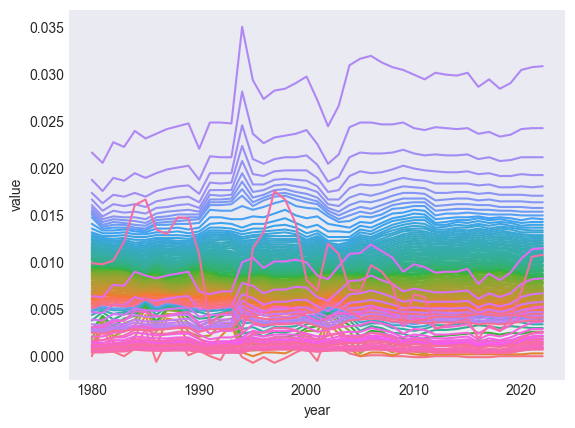

In [8]:
sns.lineplot(
    sweden_shares[
        (sweden_shares["variable"] == "scaincj992") * filter_percentiles(sweden_shares)
    ],
    y="value",
    x="year",
    hue="percentile",
    legend=False,
)

In [9]:
countries = pd.read_csv("wid_all_data/WID_countries.csv", sep=";")
countries

,alpha2,titlename,shortname,region,region2
0,AD,Andorra,Andorra,Europe,Western Europe
1,AE,the United Arab Emirates,United Arab Emirates,Asia,West Asia
2,AF,Afghanistan,Afghanistan,Asia,South Asia
3,AG,Antigua and Barbuda,Antigua and Barbuda,Americas,Caribbean
4,AI,Anguilla,Anguilla,Americas,Caribbean
...,...,...,...,...,...
383,YU,Yugoslavia,Yugoslavia,Europe,Eastern Europe
384,ZA,South Africa,South Africa,Africa,South Africa
385,ZM,Zambia,Zambia,Africa,East Africa
386,ZW,Zimbabwe,Zimbabwe,Africa,East Africa


In [10]:
def percentile_to_tuple(s):
    match = re.match(r"p([0-9]*\.?[0-9]+)p([0-9]*\.?[0-9]+)", s)
    if match:
        m = float(match.group(1))  # First number after 'p'
        n = float(match.group(2))  # Second number after 'p'
    else:
        raise Exception("Something went wrong")
    return (m, n)
    

In [11]:
post_tax_income= pd.DataFrame(columns=['country',
  'percentile',
  'year',
  'value',
  'age',
  'pop'])
for i, row in countries[countries["region"] == "Europe"].iterrows():
    country_code = row["alpha2"]
    country = row["titlename"]
    df = pd.read_csv("wid_all_data/WID_data_{}.csv".format(country_code), sep=";")
    df = df[(df["variable"] == "scaincj992")*filter_percentiles(df)]
    df.loc[:, "country"] = df["country"].apply(lambda x : country)
    post_tax_income = pd.concat((post_tax_income, df))

post_tax_income = post_tax_income.drop(["age", "pop", "variable"], axis=1).reset_index(drop=True)
post_tax_income.loc[:, "percentile"] = post_tax_income["percentile"].map(percentile_to_tuple)
post_tax_income = post_tax_income[
    (post_tax_income["year"] >= 2000) & (post_tax_income["year"] <= 2021)
]

C:\Users\toven\AppData\Local\Temp\ipykernel_13984\166776178.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  post_tax_income = pd.concat((post_tax_income, df))
C:\Users\toven\AppData\Local\Temp\ipykernel_13984\166776178.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  post_tax_income = pd.concat((post_tax_income, df))
C:\Users\toven\AppData\Local\Temp\ipykernel_13984\166776178.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a f

In [12]:
percentiles = np.sort(post_tax_income["percentile"].unique())
percentiles
# np.sort(post_tax_income["country"].unique())

array([(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0),
       (5.0, 6.0), (6.0, 7.0), (7.0, 8.0), (8.0, 9.0), (9.0, 10.0),
       (10.0, 11.0), (11.0, 12.0), (12.0, 13.0), (13.0, 14.0),
       (14.0, 15.0), (15.0, 16.0), (16.0, 17.0), (17.0, 18.0),
       (18.0, 19.0), (19.0, 20.0), (20.0, 21.0), (21.0, 22.0),
       (22.0, 23.0), (23.0, 24.0), (24.0, 25.0), (25.0, 26.0),
       (26.0, 27.0), (27.0, 28.0), (28.0, 29.0), (29.0, 30.0),
       (30.0, 31.0), (31.0, 32.0), (32.0, 33.0), (33.0, 34.0),
       (34.0, 35.0), (35.0, 36.0), (36.0, 37.0), (37.0, 38.0),
       (38.0, 39.0), (39.0, 40.0), (40.0, 41.0), (41.0, 42.0),
       (42.0, 43.0), (43.0, 44.0), (44.0, 45.0), (45.0, 46.0),
       (46.0, 47.0), (47.0, 48.0), (48.0, 49.0), (49.0, 50.0),
       (50.0, 51.0), (51.0, 52.0), (52.0, 53.0), (53.0, 54.0),
       (54.0, 55.0), (55.0, 56.0), (56.0, 57.0), (57.0, 58.0),
       (58.0, 59.0), (59.0, 60.0), (60.0, 61.0), (61.0, 62.0),
       (62.0, 63.0), (63.0, 64.0), (64.0, 65.0

In [13]:
def check_if_all_data_exists(df):
    country_names = df["country"].unique()
    bad_countries = set()
    
    for year in df["year"].unique():
        year_df = df[df["year"] == year]
        for country in country_names:
            if len(year_df[year_df["country"] == country]["percentile"].unique()) < len(
                percentiles
            ):
                bad_countries.add(country)
                print(year, country)
    return bad_countries


bad_countries = check_if_all_data_exists(post_tax_income)
for country in bad_countries:
    post_tax_income = post_tax_income[post_tax_income["country"] != country]
print(post_tax_income["country"].unique())
country_list = list(np.sort(post_tax_income["country"].unique()))

2000 Kosovo
2000 Malta
2001 Kosovo
2001 Malta
2002 Kosovo
2002 Malta
2003 Malta
2004 Malta
2005 Malta
['Austria' 'Bosnia and Herzegovina' 'Belgium' 'Bulgaria' 'Switzerland'
 'Cyprus' 'the Czech Republic' 'Germany' 'Denmark' 'Estonia' 'Spain'
 'Finland' 'the United Kingdom' 'Greece' 'Croatia' 'Hungary' 'Ireland'
 'Iceland' 'Italy' 'Lithuania' 'Luxembourg' 'Latvia' 'Moldova'
 'Montenegro' 'North Macedonia' 'the Netherlands' 'Norway' 'Poland'
 'Portugal' 'Romania' 'Serbia' 'Sweden' 'Slovenia' 'Slovakia']


In [14]:
post_tax_income

,country,percentile,year,value
20,Austria,"(0.0, 1.0)",2000,0.0010
21,Austria,"(0.0, 1.0)",2001,0.0004
22,Austria,"(0.0, 1.0)",2002,0.0004
23,Austria,"(0.0, 1.0)",2003,0.0006
24,Austria,"(0.0, 1.0)",2004,0.0014
...,...,...,...,...
179700,Slovakia,"(9.0, 10.0)",2017,0.0037
179701,Slovakia,"(9.0, 10.0)",2018,0.0033
179702,Slovakia,"(9.0, 10.0)",2019,0.0040
179703,Slovakia,"(9.0, 10.0)",2020,0.0040


In [15]:
def gen_cumulative_distributions(df):
    res =  {year : {country : np.zeros((len(percentiles), 2)) for country in df["country"].unique()} for year in df["year"].unique()}
    for year in df["year"].unique():
        year_df = df[df["year"] == year]
        print(year)
        for country_name in df["country"].unique():
            x = [0, 0]
            y = [0.0, 0.0]
            country_df = year_df[year_df["country"] == country_name]
            for i, percentile in enumerate(percentiles):
                value =country_df[country_df["percentile"] == percentile
                ]["value"]
                if value.shape[0] == 0:
                    res[year][country_name][:, :] = np.nan
                    print(year, country_name)
                    break
                else:
                    res[year][country_name][i, :] = np.array((percentile[1], res[year][country_name][max([0, i-1]), 1] + value.iloc[0]))
    return res
cum_dists = gen_cumulative_distributions(post_tax_income)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


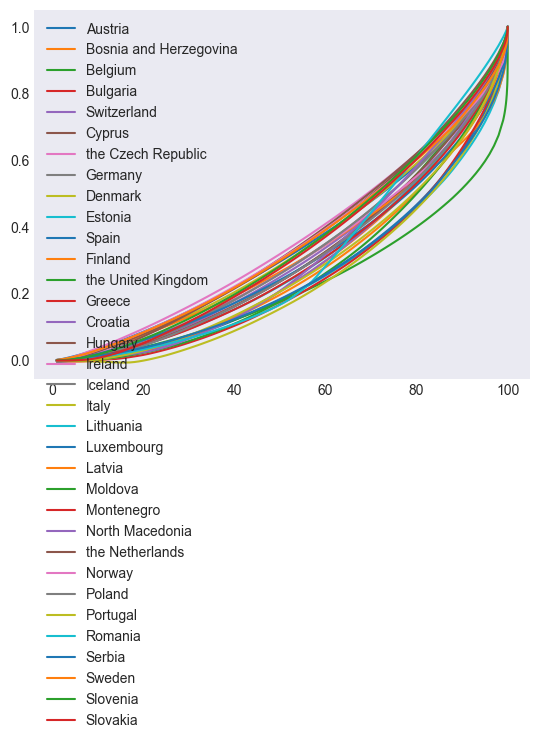

In [ ]:
def plot_distribution(ax, cumulative_df, country_names, year):
    for country in country_names:
        ax.plot(cumulative_df[year][country][:, 0], cumulative_df[year][country][:, 1], label = country)
    ax.legend()




    

In [23]:
def calculate_gini(cumulative_df, years, countries):
    res = {year: {country : 0.0 for country in countries}for year in years}
    for year in years:
        for country in countries:
            area_under = 0.0
            for i in range(1, cumulative_df[year][country].shape[0]):
                delta_x = (
                    cumulative_df[year][country][i, 0]
                    - cumulative_df[year][country][i - 1, 0]
                )
                area_under += (
                    delta_x
                    * 0.5
                    * (
                        cumulative_df[year][country][i, 1]
                        + cumulative_df[year][country][i-1, 1]
                    )
                )
            res[year][country] =  (50- area_under) / (50)
    return res

gini_dict = calculate_gini(cum_dists, cum_dists.keys(), country_list)
gini_df = pd.DataFrame(gini_dict)
countries_to_plot_gini = (
    gini_df[2000].sort_values().head(5).index.to_list()
    + gini_df[2000].sort_values(ascending=False).head(5).index.to_list()
)

In [29]:
gini_df[2020]["the Czech Republic"]


0.29325904399999997

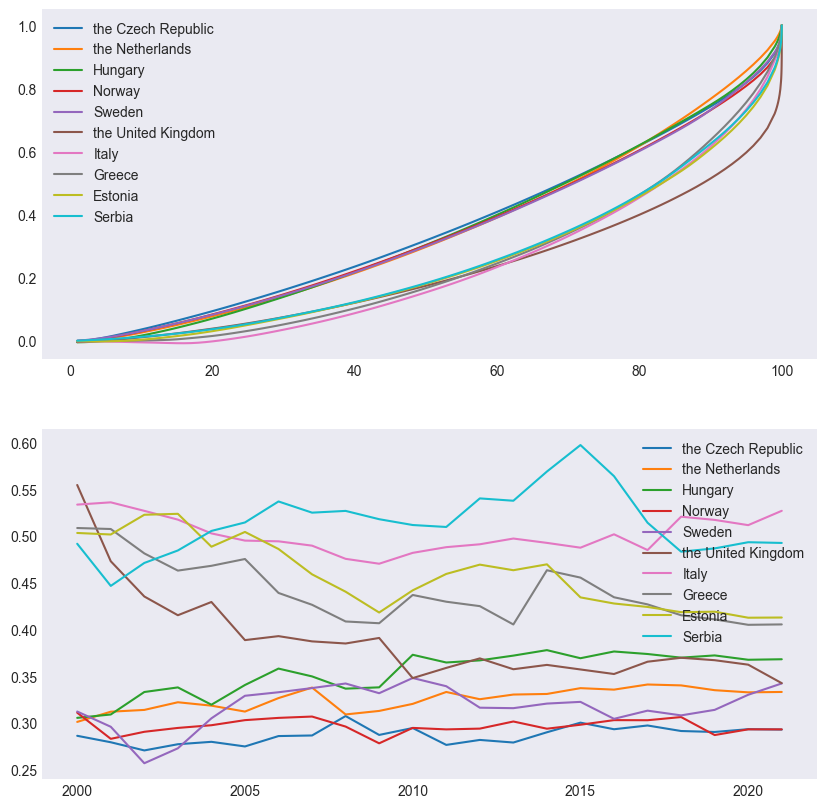

In [26]:
fig, ax = plt.subplots(2, figsize = (10, 10))
plot_distribution(ax[0], cum_dists, countries_to_plot_gini, 2000)
for country in countries_to_plot_gini:
    ax[1].plot(gini_df.columns, [gini_df[year][country] for year in gini_df.columns], label = country)
ax[1].legend()


In [ ]:
def gen_lp_distances(cumul_dist_dict, p):
    n_countries = len(country_list)
    distance_dict = {
        year: np.zeros((n_countries, n_countries), float)
        for year in cumul_dist_dict.keys()
    }
    for year in cumul_dist_dict.keys():
        for country, other_country in itertools.combinations(cumul_dist_dict[year].keys(), r=2):

            index = country_list.index(country)
            other_index = country_list.index(other_country)
            distance = 0.0
            for i in range(1, cumul_dist_dict[year][country].shape[0]):
                delta_x = (
                    cumul_dist_dict[year][country][i, 0]
                    - cumul_dist_dict[year][country][i - 1, 0]
                )
                distance += delta_x * (
                    cumul_dist_dict[year][country][i, 1]
                    - cumul_dist_dict[year][other_country][i, 1]
                )**p
            distance = distance**(1/p)
            distance_dict[year][index, other_index] = distance
    return distance_dict
distance_dict = gen_lp_distances(cum_dists, 2)

## Analysis


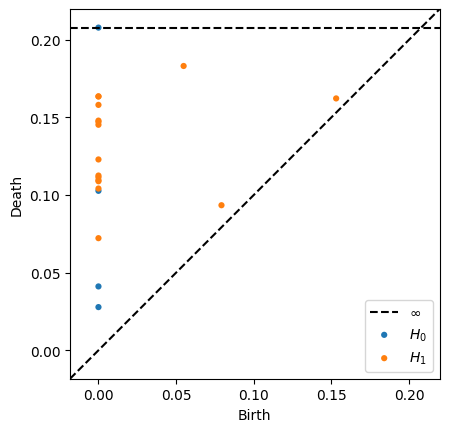

In [ ]:
rip = ripser.ripser(distance_dict[2007], distance_matrix=True)["dgms"]
plot_diagrams(rip)